In [1]:
from IPython.core.display import Image, display
display(Image(url='https://www.greekmythology.com/images/mythology/aegis_228.jpg', width=200, unconfined=True))

/tmp/ipykernel_269689/4129434108.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [2]:
import numpy as np
import healpy as hp
import pickle as pk
import torch
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import os
import sys
sys.path.append('../astroLFI')
import LFI_galactic_center
from sources import FermiBackgrounds
from sources import Model_O
from sources import DMsignal
from sources import smoothDM
from sources import MSP
from sources import Fermi_Bubbles
from sbi.inference import SNLE, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from getdist import plots, MCSamples

%matplotlib inline

In [3]:
parameter_range = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [2000, 100000] #MeV
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
luminosity_range = 10.0**np.array([30, 37])
max_radius = 8.5 + 20*2 #kpc
#exposure = 10*2000*10*0.2 #cm^2 yr
exposure = 2000*10*0.2 #cm^2 yr
#exposure = 200*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
#flux_cut = np.inf
angular_cut = 10*u.deg.to('rad') #degrees
angular_cut_gen = angular_cut*1.5
lat_cut = 2*u.deg.to('rad') #degrees
lat_cut_gen = lat_cut*0.5

In [3]:
# Add core non-poisson millisecond pulsar source clase
start1_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
my_MSP = MSP.MSP(spec_file_path)
def R_core_np_wrap(r, params):
    A = params[start1_i]
    #A = 0.035
    r_s = 20 #kpc
    gamma = 1.2
    return A * my_MSP.gNFW(r, r_s, gamma)**2

def Theta_core_np_wrap(theta, params):
    return np.ones(np.shape(theta))
    #return np.concatenate((np.zeros(np.round(np.size(theta)/2).astype('int')), np.ones(np.round(np.size(theta)/2).astype('int')-1)))
    #return np.sin(theta)**10

def Phi_core_np_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_core_np_wrap(L, params):
    n_1 = -0.66
    n_2 = 18.2
    #L_b = params[start1_i+1] #1e34
    L_b = 1.56e37/2.35 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_core_np_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{core}')
parameter_range[0].append(0.)
parameter_range[1].append(0.07)
#parameter_range[0].append(5e33)
#parameter_range[1].append(1.5e34)
MSP_core_np_als = [(R_core_np_wrap, Theta_core_np_wrap, Phi_core_np_wrap), L_core_np_wrap, spec_core_np_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_core_np_als)
source_class_list.append('independent_spherical_multi_spectra')

NameError: name 'parameter_range' is not defined

In [4]:
# Add core poisson millisecond pulsar source clase
start1_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
my_MSP = MSP.MSP(spec_file_path)
def R_core_p_wrap(r, params):
    A = params[start1_i]
    #A = 1.0
    r_s = 20 #kpc
    gamma = 1.2
    return A * my_MSP.gNFW(r, r_s, gamma)**2

def Theta_core_p_wrap(theta, params):
    return np.ones(np.shape(theta))
    #return np.concatenate((np.zeros(np.round(np.size(theta)/2).astype('int')), np.ones(np.round(np.size(theta)/2).astype('int')-1)))
    #return np.sin(theta)**10

def Phi_core_p_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_core_p_wrap(L, params):
    n_1 = 0.97
    n_2 = 2.6
    #L_b = params[start1_i+1] #1e34
    L_b = 1.061e36/2.25 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_core_p_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{core}')
parameter_range[0].append(0.)
parameter_range[1].append(3.)
#parameter_range[0].append(5e33)
#parameter_range[1].append(1.5e34)
MSP_core_p_als = [(R_core_p_wrap, Theta_core_p_wrap, Phi_core_p_wrap), L_core_p_wrap, spec_core_p_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_core_p_als)
source_class_list.append('independent_spherical_multi_spectra')

In [5]:
# Add disk non-poisson millisecond pulsar source clase
start2_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
disk_file_path = '../data/MSP/Buschmann_etal_2020_fig7_disk.csv'
GCE_file_path = '../data/MSP/Buschmann_etal_2020_fig7_GCE.csv'
my_MSP = MSP.MSP(spec_file_path)
disk_to_GCE_source_count_ratio = my_MSP.get_disk_to_GCE_source_count_ratio(disk_file_path, GCE_file_path)
print('non-poisson disk excpected source count = ', 970*disk_to_GCE_source_count_ratio)
def R_disk_np_wrap(r, params):
    A = params[start2_i]
    #A = 0.25
    r_d = 5 #kpc
    gamma = 1.2
    return A * my_MSP.disk_R_MS(r, r_d)

def Z_disk_np_wrap(z, params):
    z_s = 0.3 #kpc
    return my_MSP.disk_Z_MS(z, z_s)

def Phi_disk_np_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_disk_np_wrap(L, params):
    n_1 = -0.66
    n_2 = 18.2
    #L_b = params[1] #1e34
    L_b = 1.56e37/2.25 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_disk_np_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{disk}')
parameter_range[0].append(0.)
parameter_range[1].append(2.)
MSP_disk_np_als = [(R_disk_np_wrap, Z_disk_np_wrap, Phi_disk_np_wrap), L_disk_np_wrap, spec_disk_np_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_disk_np_als)
source_class_list.append('independent_cylindrical_multi_spectra')

non-poisson disk excpected source count =  1.8533745787762563


In [5]:
# Add disk poisson millisecond pulsar source clase
start2_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
disk_file_path = '../data/MSP/Buschmann_etal_2020_fig7_disk.csv'
GCE_file_path = '../data/MSP/Buschmann_etal_2020_fig7_GCE.csv'
my_MSP = MSP.MSP(spec_file_path)
disk_to_GCE_source_count_ratio = my_MSP.get_disk_to_GCE_source_count_ratio(disk_file_path, GCE_file_path)
print('poisson disk excpected source count = ', 2.6e4*disk_to_GCE_source_count_ratio)
def R_disk_p_wrap(r, params):
    A = params[start2_i]
    #A = 5.0
    r_d = 5 #kpc
    gamma = 1.2
    return A * my_MSP.disk_R_MS(r, r_d)

def Z_disk_p_wrap(z, params):
    z_s = 0.3 #kpc
    return my_MSP.disk_Z_MS(z, z_s)

def Phi_disk_p_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_disk_p_wrap(L, params):
    n_1 = 0.97
    n_2 = 2.60
    #L_b = params[1] #1e34
    L_b = 1.061e36/2.25 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_disk_p_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{disk}')
parameter_range[0].append(0.)
parameter_range[1].append(15.)
MSP_disk_p_als = [(R_disk_p_wrap, Z_disk_p_wrap, Phi_disk_p_wrap), L_disk_p_wrap, spec_disk_p_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_disk_p_als)
source_class_list.append('independent_cylindrical_multi_spectra')

poisson disk excpected source count =  49.67808149297182


In [6]:
# Add dark matter halo signal
start3_i = np.size(parameter_range[0])
N_side_DM = 2**8
N_Ebins_DM = 100
settings = {'N_side': N_side_DM, 'theta_cutoff': angular_cut, 'halo_dist': 8.5*u.kpc.to('cm'), 'Rs': 20*u.kpc.to('cm'), 'mass_func': 'gNFW'}
my_DM_flux = smoothDM.smoothDM(**settings)
channel = 'b'
DM_directory = '../data/dm_spectra/'
my_DM_signal = DMsignal.DMsignal(DM_directory, channel)
fix_spec_to_MSP_mean = False

def DM_wrap(params):
    DM_mass = params[start3_i] #MeV
    #DM_mass = 30000 #MeV
    cross_sec = params[start3_i + 1]*1e-26 #cm^3 s^-1
    #cross_sec = params[start3_i]*1e-26 #cm^3 s^-1
    rho_s = 1.06e-2*u.Msun.to('kg')*c.c.value**2*u.J.to('MeV')/u.pc.to('cm')**3
    r_s = 20*u.kpc.to('cm')
    gamma = 1.2
    DM_energies = np.geomspace(energy_range[0], energy_range[1], N_Ebins_DM+1) #MeV
    dNdE = my_DM_signal.get_dNdE(DM_energies, channel, DM_mass)
    if fix_spec_to_MSP_mean:
        spec_file_path = '../data/MSP/1407_5583.txt'
        mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
        my_MSP = MSP.MSP(spec_file_path)
        mean_spec = my_MSP.MSP_spectra_load(DM_energies, mean_spec_file_path, 1)[0,:]
        dNdE = mean_spec*np.sum(dNdE[:-1]*(DM_energies[1:]-DM_energies[:-1]))
    mass_func_params = (r_s, rho_s, gamma)
    DM_map, DM_indices = my_DM_flux.get_map(DM_mass, cross_sec, dNdE, mass_func_params)
    return DM_map.T, DM_energies, DM_indices, N_side_DM

parameter_names.append(r'm_{\chi}')
parameter_range[0].append(10000.)
parameter_range[1].append(100000.)
parameter_names.append(r'\langle\sigma_{DM} v\rangle_0')
parameter_range[0].append(0.)
parameter_range[1].append(10.0)
DM_als = [DM_wrap]
abundance_luminosity_and_spectrum_list.append(DM_als)
source_class_list.append('healpix_map')

In [7]:
# Add Fermi isotropic background source class
my_FB = FermiBackgrounds.FermiBackgrounds('..')
def spec_iso_wrap(energy, params):
    iso_fit = my_FB.get_isotropic_background_spectrum_func()
    return iso_fit(energy)
FIB_als = [spec_iso_wrap]
abundance_luminosity_and_spectrum_list.append(FIB_als)
source_class_list.append('isotropic_diffuse')

In [4]:
# Add Fermi nonisotropic background source class
my_FB = FermiBackgrounds.FermiBackgrounds('..')
N_side_FB = 2**9
N_Ebins = 1500
FB_map, FB_energies, FB_indices = my_FB.get_partial_nonistropic_background(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins, N_side_FB)
'''
FNB_dict = my_FB.get_nonistropic_background(N_side_FB = 2**10)
map_all = FNB_dict['galactic_bg']
map_E = FNB_dict['energies_MeV']
gal_bg_data = pk.load(open('../data/FermiData/galactic_bg_healpix_Nside128.pk','rb'))
map_all = gal_bg_data['galactic_bg']
map_E = gal_bg_data['energies_MeV']
'''

def FNB_wrap(params):
    return FB_map, FB_energies, FB_indices, N_side_FB

FNB_als = [FNB_wrap]
abundance_luminosity_and_spectrum_list.append(FNB_als)
source_class_list.append('healpix_map')

parameter_names = ['A_{core}', 'A_{disk}', r'm_{\chi}', r'\langle\sigma_{DM} v\rangle_0', r'A_{O}']
parameter_range = [[0., 0., 500000., 0., 0.5], [0.07, 2., 1000000., 30., 1.5]] #nonpoisson extendedDM2
#parameter_range = [[0., 0., 500000., 0., 0.5], [3., 15., 1000000., 30., 1.5]] #poisson extendedDM
#parameter_range = [[0., 0., 400000., 0., 0.5], [0.07, 2., 800000., 30., 1.5]] #nonpoisson limitedDM
#parameter_range = [[0., 0., 400000., 0., 0.5], [3., 15., 800000., 30., 1.5]] #poisson limitedDM

In [8]:
# Add Model O source class
start4_i = np.size(parameter_range[0])
N_side_MO = 2**8
N_Ebins_MO = 1500
my_MO = Model_O.Model_O('..')

# inverse compton scattering model:
MO_ics_map, MO_ics_energies, MO_ics_indices = my_MO.get_partial_map_ics(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins_MO, N_side_MO)
def MO_ics_wrap(params):
    A_O = 1
    #A_O = params[start4_i]
    return A_O*MO_ics_map, MO_ics_energies, MO_ics_indices, N_side_MO

MO_ics_als = [MO_ics_wrap]
abundance_luminosity_and_spectrum_list.append(MO_ics_als)
source_class_list.append('healpix_map')

# pi^0 + Bremsstrahlung model:
MO_pibrem_map, MO_pibrem_energies, MO_pibrem_indices = my_MO.get_partial_map_pibrem(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins_MO, N_side_MO)
def MO_pibrem_wrap(params):
    A_O = 1
    #A_O = params[start4_i]
    return A_O*MO_pibrem_map, MO_pibrem_energies, MO_pibrem_indices, N_side_MO

#parameter_names.append(r'A_{O}')
#parameter_range[0].append(0.5)
#parameter_range[1].append(1.5)
MO_pibrem_als = [MO_pibrem_wrap]
abundance_luminosity_and_spectrum_list.append(MO_pibrem_als)
source_class_list.append('healpix_map')

In [9]:
display(Image(url='https://cdn.shopify.com/s/files/1/0605/9520/8383/files/logo-modelo_008b34f4-c9a9-4164-a0b8-f8950a4c79b9_large.png?v=1638135925', width=200, unconfined=True))
my_MO = Model_O.Model_O('..')

In [10]:
# Add Fermi Bubbles source class
my_FBub = Fermi_Bubbles.Fermi_Bubbles('..')
N_side_FBub = 2**8
N_Ebins_FBub = 1500

FBub_map, FBub_energies, FBub_indices = my_FBub.get_partial_map(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins_FBub, N_side_FBub)
def FBub_wrap(params):
    return FBub_map, FBub_energies, FBub_indices, N_side_FBub

FBub_als = [FBub_wrap]
abundance_luminosity_and_spectrum_list.append(FBub_als)
source_class_list.append('healpix_map')

In [5]:
my_LFI = LFI_galactic_center.LFI_G(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, verbose = False)
my_LFI.angular_cut_gen, my_LFI.lat_cut_gen, my_LFI.Emin_gen, my_LFI.Emax_gen = angular_cut_gen, lat_cut_gen, energy_range_gen[0], energy_range_gen[1]

Max count in any pixel/energy bin:  191.0
Number of sources:  0
Number of photons:  57137
Average photon energy:  5.43436244762987  GeV
Average luminosity/source (only valid when running single source):  nan $ erg s^{-1}$
Approximate Flux:  3.941054763536635e-09 $ erg cm^{-2}s^{-1}$
Number of pixels:  280
Size of pixels (deg): 0.9161297098179749


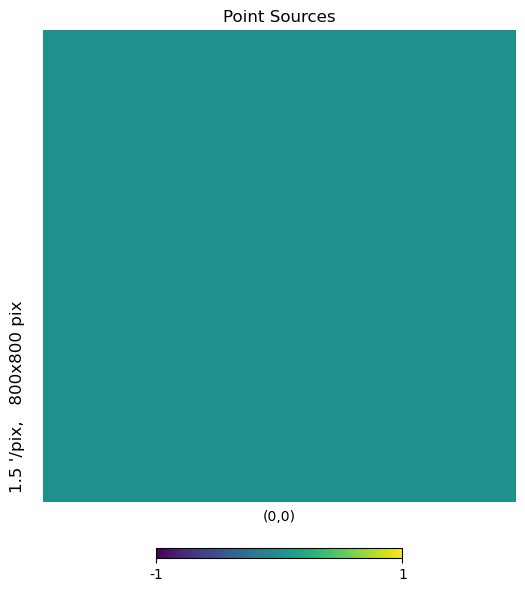

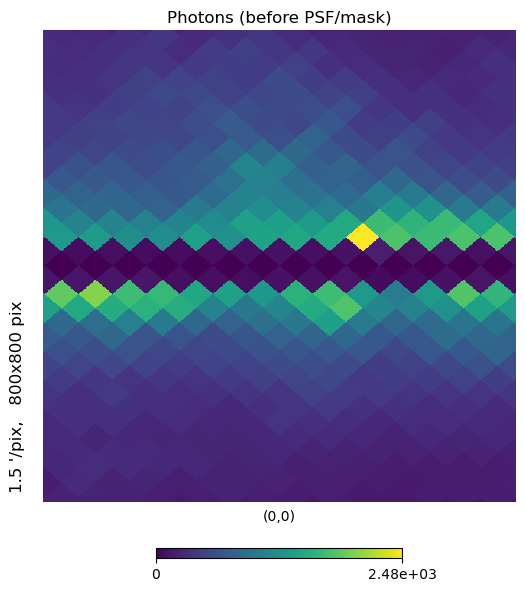

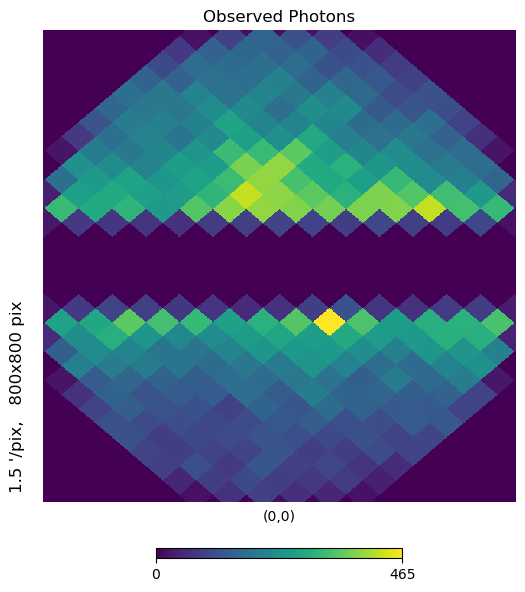

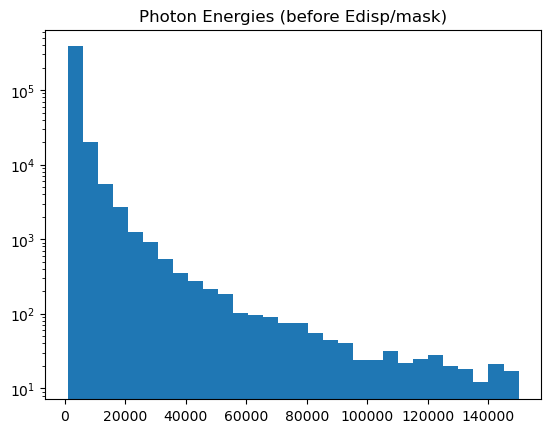

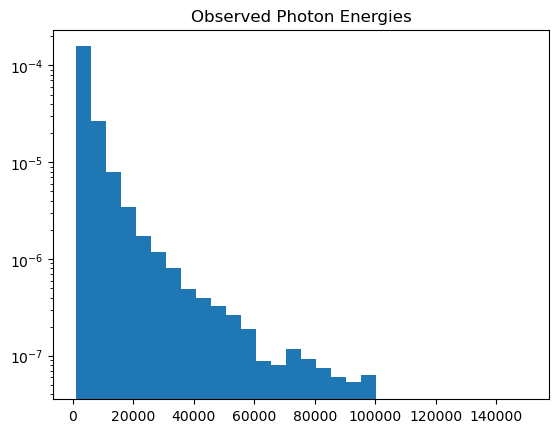

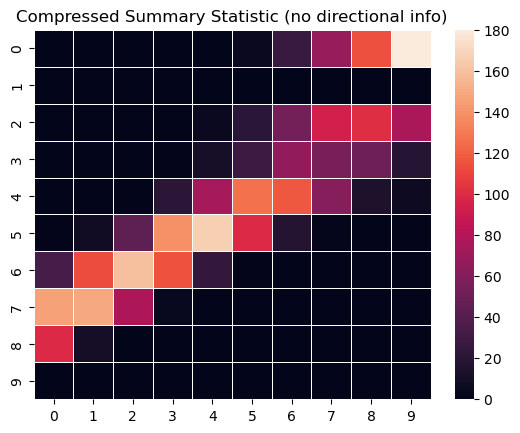

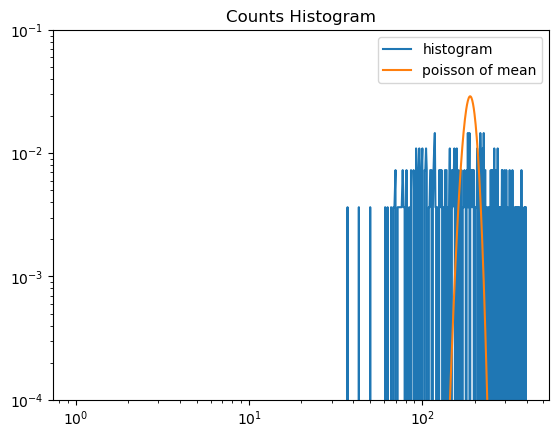

In [10]:
#input_params = [1.0, 5.0] #poisson only pulsars, only number normalizations
#input_params = [0.035, 0.25] #non-poisson only pulsars, only number normalizations
#input_params = [70000, 3] #DM mass and cross section
#input_params = [2., 6.0, 30000, 0] #poisson pulsars, only number normalizations, DM mass and cross section
input_params = [0.022, 0.25, 30000, 1] #nonpoisson pulsars, only number normalizations, DM mass and cross section
#input_params = [0.035, 0.25, 30000, 3, 1] #nonpoisson pulsars, only number normalizations, DM mass and cross section, Model O normalization
#input_params = [1., 3] #poisson run 6
#input_params = [0.035, 3] #nonpoisson run 6

source_info = my_LFI.create_sources(input_params, grains = 10000)
photon_info = my_LFI.generate_photons_from_sources(input_params, source_info)
obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)

N_side = 2**6
heatmap = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.gnomview(heatmap[0], title = 'Point Sources', xsize = int(round(2*angular_cut*u.rad.to('arcmin')/1.5)), reso = 1.5)

heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.gnomview(heatmap[0], title = 'Photons (before PSF/mask)', xsize = int(round(2*angular_cut*u.rad.to('arcmin')/1.5)), reso = 1.5)

heatmap = np.histogram(hp.ang2pix(N_side, obs_photon_info['angles'][:,0], obs_photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.gnomview(heatmap[0], title = 'Observed Photons', xsize = int(round(2*angular_cut*u.rad.to('arcmin')/1.5)), reso = 1.5)

fig, ax = plt.subplots()
ax.set_title('Photon Energies (before Edisp/mask)')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.hist(photon_info['energies'], bins = 30, range = energy_range_gen)

fig, ax = plt.subplots()
ax.set_title('Observed Photon Energies')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.hist(obs_photon_info['energies'], bins = 30, range = energy_range_gen, density = True)

roi_map = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins = 10, Ebinspace = 'log')
print('Max count in any pixel/energy bin: ', np.max(roi_map))
counts_hist = my_LFI.get_counts_histogram_from_roi_map(roi_map, mincount = 0, maxcount = 500, N_countbins = 10, countbinspace = 'log')
fig, ax = plt.subplots()
ax.set_title('Compressed Summary Statistic (no directional info)')
ax = sns.heatmap(counts_hist, linewidth=0.5)

fig, ax = plt.subplots()
ax.set_title('Counts Histogram')
for i in range(1):
    source_info = my_LFI.create_sources(input_params, grains = 10000)
    photon_info = my_LFI.generate_photons_from_sources(input_params, source_info)
    obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    roi_map = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins = 1, Ebinspace = 'log')
    if i == 0:
        counts_hist = my_LFI.get_counts_histogram_from_roi_map(roi_map, mincount = 0, maxcount = 400, N_countbins = 400, countbinspace = 'linear')
    else:
        counts_hist += my_LFI.get_counts_histogram_from_roi_map(roi_map, mincount = 0, maxcount = 400, N_countbins = 400, countbinspace = 'linear')
counts_hist /= np.sum(counts_hist)
counts_bins = np.linspace(0, 400, 401)
ax.plot(counts_bins[:-1], counts_hist, label = 'histogram')
mean = np.sum(counts_hist.T[0]*counts_bins[:-1])
plotc = np.linspace(0, 400, 401)
import scipy as sp
ax.plot(plotc, sp.stats.poisson.pmf(plotc, mean), label = 'poisson of mean')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-4, 1e-1)
ax.legend()

print('Number of sources: ', np.size(source_info['distances']))
print('Number of photons: ', np.size(obs_photon_info['energies']))
print('Average photon energy: ', np.mean(obs_photon_info['energies'])/1000, ' GeV')
print('Average luminosity/source (only valid when running single source): ', np.mean(source_info['luminosities'])*np.mean(photon_info['energies'])*u.MeV.to('erg'), r'$ erg s^{-1}$')
print('Approximate Flux: ', np.mean(obs_photon_info['energies'])*u.MeV.to('erg')*np.size(obs_photon_info['energies'])/(exposure*u.yr.to('s')), r'$ erg cm^{-2}s^{-1}$')
print('Number of pixels: ', roi_map.shape[0])#round(12*N_side**2*(2*np.pi*(1 - np.cos(angular_cut)))/(4*np.pi)))
print('Size of pixels (deg):', hp.nside2resol(N_side)*u.rad.to('deg'))

In [13]:
bign = np.argmax(source_info['luminosities'])
print(source_info['luminosities'][bign])
print(source_info['distances'][bign])
print(source_info['types'][bign])

9.55868257546235e+36
14.280038216839547
0.0


In [9]:
#prevents simulator from generating unique photons when called if True
static_observation = False
static_source_info = my_LFI.create_sources(input_params, grains = 4000)
static_photon_info = my_LFI.generate_photons_from_sources(input_params, source_info, grains = 1000)
static_obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
#static_obs_photon_info = my_LFI.mock_observe(static_photon_info, static_obs_info)
static_obs_photon_info = my_LFI.apply_exposure(static_photon_info, static_obs_info)
static_obs_photon_info = my_LFI.apply_PSF(static_obs_photon_info, static_obs_info, single_energy_psf = False)
static_obs_photon_info = my_LFI.apply_energy_dispersion(static_obs_photon_info, static_obs_info, single_energy_ed = False)

In [10]:
#sbi
def simulator(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 10
    mincount = 0
    maxcount = 200
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return heatmap_combined
#input_params = torch.tensor(input_params)
#observation = simulator(input_params)
prior = utils.BoxUniform(low = parameter_range[0], high = parameter_range[1])
#prior = utils.BoxUniform(low = parameter_range[0], high = parameter_range[1], device='cuda')

In [11]:
load_posterior = True
load_sims = True
run = 'run9a_nonpoisson'
numsims = '100000sims'

posterior_path = 'posteriors/' + run + '/'
posterior_file = posterior_path + numsims
sim_dir = 'simulations/' + run + '/'
if load_posterior:
    posterior = np.load(posterior_file + '.npy', allow_pickle=True)[()]
else:
    if load_sims:
        sims = listdir(sim_dir)
        theta, x = torch.tensor([]), torch.tensor([])
        i = 0
        for sim in sims:
            i += 1
            theta_batch, x_batch = np.load(sim_dir + sim, allow_pickle=True)
            theta = torch.cat((theta, theta_batch))
            x = torch.cat((x, x_batch))
            print(i,sim)
            if i == 1000:
                break
    else:
        simulator, prior = prepare_for_sbi(simulator, prior)
        theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10)
    inference = SNPE(prior=prior)
    #inference = SNPE(prior=prior, device='cuda')
    inference = inference.append_simulations(theta, x)
    density_estimator = inference.train()
    posterior = inference.build_posterior(density_estimator)
    os.makedirs(posterior_path, exist_ok=True)
    np.save(posterior_file, posterior, allow_pickle=True)

1 sim_829.npy
2 sim_23.npy
3 sim_162.npy
4 sim_971.npy
5 sim_503.npy
6 sim_275.npy
7 sim_614.npy
8 sim_351.npy
9 sim_884.npy
10 sim_730.npy
11 sim_1000.npy
12 sim_380.npy
13 sim_427.npy
14 sim_855.npy
15 sim_209.npy
16 sim_668.npy
17 sim_883.npy
18 sim_356.npy
19 sim_89.npy
20 sim_737.npy
21 sim_58.npy
22 sim_852.npy
23 sim_420.npy
24 sim_387.npy
25 sim_119.npy
26 sim_578.npy
27 sim_24.npy
28 sim_165.npy
29 sim_504.npy
30 sim_976.npy
31 sim_272.npy
32 sim_613.npy
33 sim_87.npy
34 sim_358.npy
35 sim_739.npy
36 sim_389.npy
37 sim_56.npy
38 sim_117.npy
39 sim_576.npy
40 sim_904.npy
41 sim_200.npy
42 sim_661.npy
43 sim_324.npy
44 sim_483.npy
45 sim_745.npy
46 sim_794.npy
47 sim_820.npy
48 sim_452.npy
49 sim_978.npy
50 sim_484.npy
51 sim_323.npy
52 sim_742.npy
53 sim_793.npy
54 sim_455.npy
55 sim_827.npy
56 sim_80.npy
57 sim_51.npy
58 sim_429.npy
59 sim_110.npy
60 sim_903.npy
61 sim_571.npy
62 sim_207.npy
63 sim_666.npy
64 sim_18.npy
65 sim_460.npy
66 sim_812.npy
67 sim_777.npy
68 sim_316.n

562 sim_922.npy
563 sim_226.npy
564 sim_581.npy
565 sim_647.npy
566 sim_70.npy
567 sim_408.npy
568 sim_302.npy
569 sim_763.npy
570 sim_1.npy
571 sim_806.npy
572 sim_474.npy
573 sim_959.npy
574 sim_988.npy
575 sim_305.npy
576 sim_764.npy
577 sim_6.npy
578 sim_473.npy
579 sim_801.npy
580 sim_136.npy
581 sim_691.npy
582 sim_925.npy
583 sim_557.npy
584 sim_586.npy
585 sim_221.npy
586 sim_640.npy
587 sim_379.npy
588 sim_718.npy
589 sim_77.npy
590 sim_144.npy
591 sim_282.npy
592 sim_957.npy
593 sim_525.npy
594 sim_253.npy
595 sim_986.npy
596 sim_632.npy
597 sim_195.npy
598 sim_8.npy
599 sim_138.npy
600 sim_559.npy
601 sim_588.npy
602 sim_377.npy
603 sim_716.npy
604 sim_79.npy
605 sim_401.npy
606 sim_873.npy
607 sim_698.npy
608 sim_228.npy
609 sim_649.npy
610 sim_370.npy
611 sim_711.npy
612 sim_874.npy
613 sim_406.npy
614 sim_143.npy
615 sim_522.npy
616 sim_950.npy
617 sim_285.npy
618 sim_981.npy
619 sim_254.npy
620 sim_192.npy
621 sim_635.npy
622 sim_808.npy
623 sim_417.npy
624 sim_865.npy
6

In [ ]:
### input_params = torch.tensor([1.,5.])
#input_params = torch.tensor([0.035, 0.25])
#input_params = torch.tensor([50000, 3]) #DM mass and cross section
#input_params = torch.tensor([1., 3.0, 30000, 1]) #poisson 50/50
input_params = torch.tensor([2., 6.0, 30000, 0]) #poisson noDM
#input_params = torch.tensor([0.022, 0.25, 30000, 1]) #non-poisson 50/50
#input_params = torch.tensor([0.035, 0.25, 30000, 3, 1])
#input_params = torch.tensor(input_params)
observation = simulator(input_params)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
[0.e+00 7.e-02 0.e+00 2.e+00 1.e+04 1.e+05 0.e+00 1.e+01]
['a', 'b', 'c', 'd']
{'a': array([0.  , 0.07]), 'b': array([0., 2.]), 'c': array([ 10000., 100000.]), 'd': array([ 0., 10.])}
0.22413526 1.7918814


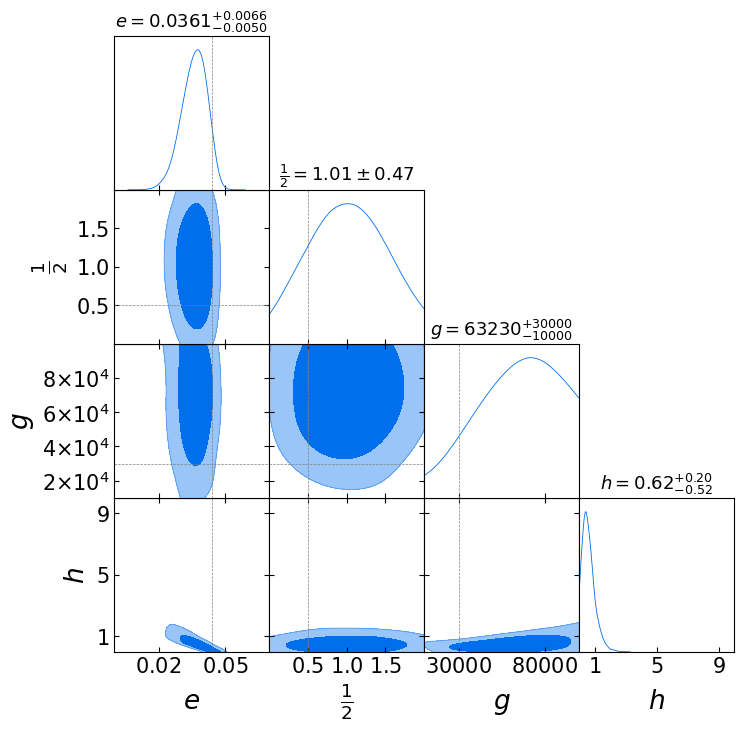

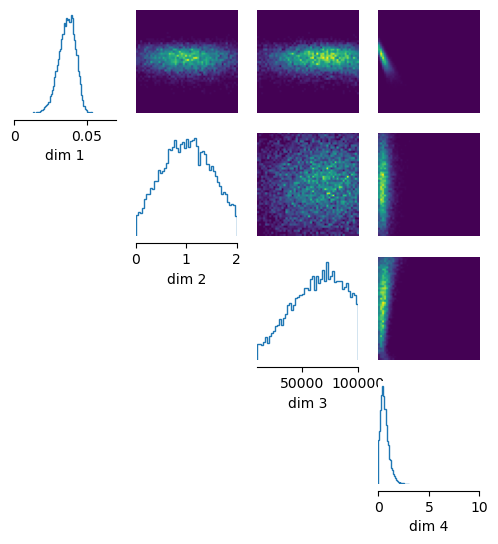

In [28]:
parameter_names = ['a','b','c','d']
parameter_labels = ['e', r'\frac{1}{2}', 'g', 'h']
samples = posterior.sample((10000,), x=observation) #100000
#print(parameter )
#log_probability = posterior.log_prob(samples, x=observation)
ranges = dict(zip(parameter_names, np.array(parameter_range).T.reshape((np.array(parameter_range[0]).size,2))))
mcsamples = MCSamples(samples=samples.numpy(), names = parameter_names, labels = parameter_labels, ranges = ranges)

g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
g.settings.axes_fontsize=18
g.settings.legend_fontsize = 26
g.settings.axes_labelsize = 22
g.settings.norm_1d_density = True
g.settings.title_limit = 1
g.triangle_plot(mcsamples, filled=True, markers=input_params.numpy(), param_limits=ranges)
analysis.pairplot(samples, limits=np.resize(np.array(parameter_range).T, (np.size(parameter_range[0]),2)), figsize=(6,6))
low = mcsamples.confidence(1, 0.05, upper = False)
high = mcsamples.confidence(1, 0.05, upper = True)
print(np.array(parameter_range).flatten('F'))
print(parameter_names)
print(ranges)
print(low, high)

In [ ]:
#g.export('figures/nominal_poisson_5050.pdf')

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


/home/chri3448/EPDF_ABC/gc_jobs/../astroLFI/LFI_galactic_center.py:720: RuntimeWarning: invalid value encountered in divide
  x_pdf = np.sum(pdf, axis = 1)/np.sum(pdf)
/home/chri3448/EPDF_ABC/gc_jobs/../astroLFI/LFI_galactic_center.py:724: RuntimeWarning: invalid value encountered in divide
  y_cdfs = np.cumsum(pdf, axis = 1)/np.tile(np.sum(pdf, axis = 1), (np.size(pdf[0,:]),1)).T


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


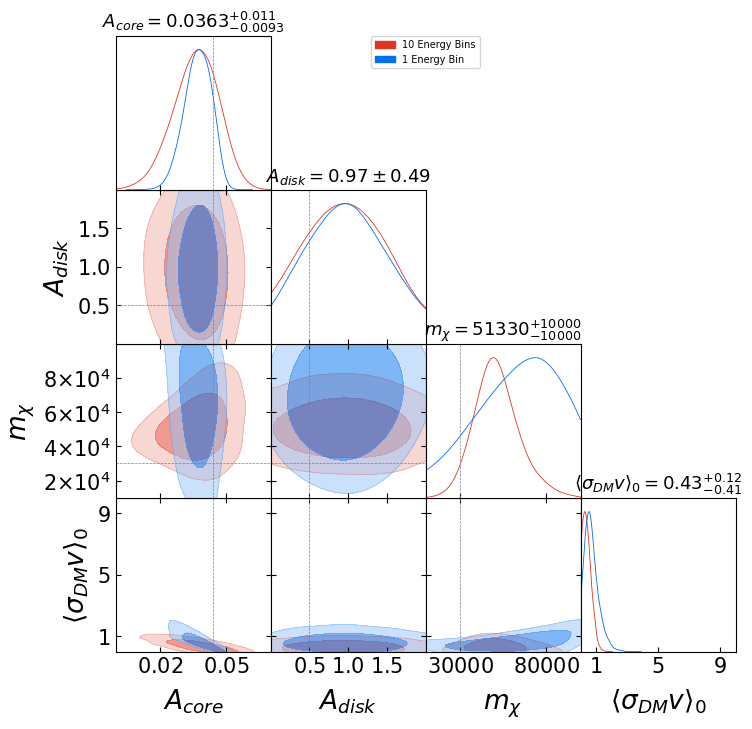

In [13]:
#overplot of contours iterated over multiple data sets

%reset
#networks = ['run5_poisson/100000sims', 'run5d_poisson/100000sims']
networks = ['run5_nonpoisson/100000sims', 'run5d_nonpoisson/100000sims']
labels = ['10 Energy Bins', '1 Energy Bin']

#input_params = torch.tensor([1., 3.0, 30000, 1]) #poisson 50/50
#input_params = torch.tensor([2., 6.0, 80000, 0]) #poisson no DM
#input_params = torch.tensor([0., 0., 30000, 2]) #poisson no PS
#input_params = torch.tensor([0.022, 0.25, 30000, 1]) #non-poisson 50/50
input_params = torch.tensor([0.044, 0.5, 30000, 0]) #non-poisson no DM
#input_params = torch.tensor([0., 0., 30000, 2]) #non-poisson no PS

#file = 'figures/ebin_test_poisson_5050.pdf'
#file = 'figures/ebin_test_poisson_noDM.pdf'
#file = 'figures/ebin_test_poisson_noPS.pdf'
#file = 'figures/ebin_test_nonpoisson_5050.pdf'
file = 'figures/ebin_test_nonpoisson_noDM.pdf'
#file = 'figures/ebin_test_nonpoisson_noPS.pdf'

num_overplots = 1
static_observation = True #prevents simulator(s) from generating unique photons when called if True

def simulator1(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 10
    mincount = 0
    maxcount = 200
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return heatmap_combined
def simulator2(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 1
    mincount = 0
    maxcount = 200
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return heatmap_combined
simulators = [simulator1, simulator2]
static_source_info = my_LFI.create_sources(input_params.numpy(), grains = 4000)
static_photon_info = my_LFI.generate_photons_from_sources(input_params.numpy(), static_source_info, grains = 1000)
static_obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
static_obs_photon_info = my_LFI.mock_observe(static_photon_info, static_obs_info)

g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
g.settings.axes_fontsize=18
g.settings.legend_fontsize = 10
g.settings.axes_labelsize = 22
g.settings.title_limit = 1
samps = []
for ni, network in enumerate(networks):
    for i in range(num_overplots):
        posterior_file = 'posteriors/' + network
        posterior = np.load(posterior_file + '.npy', allow_pickle=True)[()]
        observation = simulators[ni](input_params)
        samples = posterior.sample((10000,), x=observation) #100000
        #print(parameter )
        #log_probability = posterior.log_prob(samples, x=observation)
        ranges = dict(zip(['a','b','c','d'], np.array(parameter_range).T.reshape((np.array(parameter_range[0]).size,2))))
        #label = network + f' data set {i+1}' 
        label = labels[ni]
        samps.append(MCSamples(samples=samples.numpy(), names = ['a','b','c','d'], labels = parameter_names, label = label, ranges = ranges))
g.triangle_plot(samps, filled=True, markers=input_params.numpy(), contour_args = {'alpha': .5}, param_limits=ranges)

In [14]:
g.export(file)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


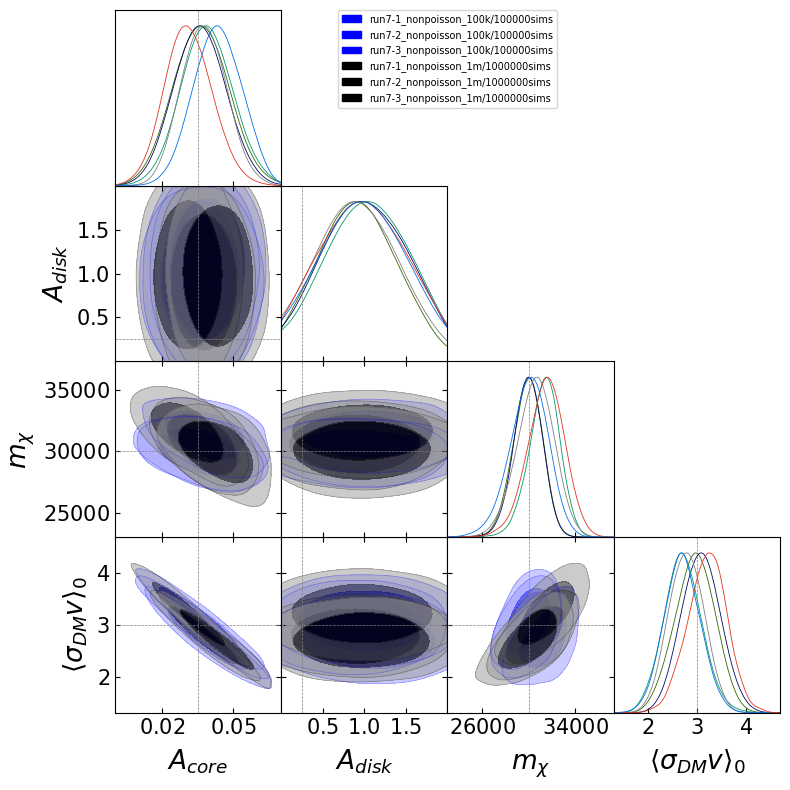

In [19]:
networks = ['run7-1_nonpoisson_100k/100000sims', 'run7-2_nonpoisson_100k/100000sims', 'run7-3_nonpoisson_100k/100000sims', 'run7-1_nonpoisson_1m/1000000sims', 'run7-2_nonpoisson_1m/1000000sims', 'run7-3_nonpoisson_1m/1000000sims']
colors = ['b', 'b', 'b', 'k', 'k', 'k']
#input_params = torch.tensor([1., 3.0, 30000, 3]) #poisson
#input_params = torch.tensor([1., 3.0, 30000, 0]) #poisson no DM
input_params = torch.tensor([0.035, 0.25, 30000, 3]) #non-poisson
#input_params = torch.tensor([0.035, 0.25, 30000, 0]) #non-poisson no DM
#input_params = torch.tensor([0., 0., 30000, 3]) #non-poisson no pulsars
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
g.settings.axes_fontsize=18
g.settings.legend_fontsize = 10
g.settings.axes_labelsize = 22
samps = []
observation = simulator(input_params)
for ni, network in enumerate(networks):
    posterior_file = 'posteriors/' + network
    posterior = np.load(posterior_file + '.npy', allow_pickle=True)[()]
    samples = posterior.sample((10000,), x=observation) #100000
    #print(parameter )
    #log_probability = posterior.log_prob(samples, x=observation)
    ranges = dict(zip(parameter_names, np.array(parameter_range).T.reshape((np.array(parameter_range[0]).size,2))))
    label = network 
    samps.append(MCSamples(samples=samples.numpy(), names = parameter_names, labels = parameter_names, label = label, ranges = ranges))
g.triangle_plot(samps, filled=True, markers=input_params.numpy(), contour_args = {'alpha': .5}, colors = colors)#, param_limits=ranges)
g.export('figures/overplot_nonpoisson_100k_1m.pdf')

In [30]:
#mean values and standard deviations

num_sims = 100
num_samples = 10000
means = np.zeros((num_sims, np.size(parameter_range[0])))
stds = np.zeros((num_sims, np.size(parameter_range[0])))
for i in range(num_sims):
    observation = simulator(input_params)
    samples = posterior.sample((num_samples,), x=observation).numpy()
    means[i,:] = np.sum(samples, axis = 0)/num_samples
    stds[i,:] = np.sqrt(np.sum((np.tile(means[i,:], (num_samples, 1)) - samples)**2, axis = 0)/(num_samples - 1))
sim_means = np.sum(means, axis = 0)/num_sims
sim_stds = np.sqrt(np.sum(stds**2, axis = 0))/num_sims
print(sim_means)
print(sim_stds)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/chri3448/EPDF_ABC/gc_jobs/../astroLFI/LFI_galactic_center.py:416: RuntimeWarning: invalid value encountered in arccos
  earth_angles[:,1] = np.arccos(x/distances/np.sin(earth_angles[:,0]))


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.03513038 2.97385976]
[0.00066833 0.024029  ]


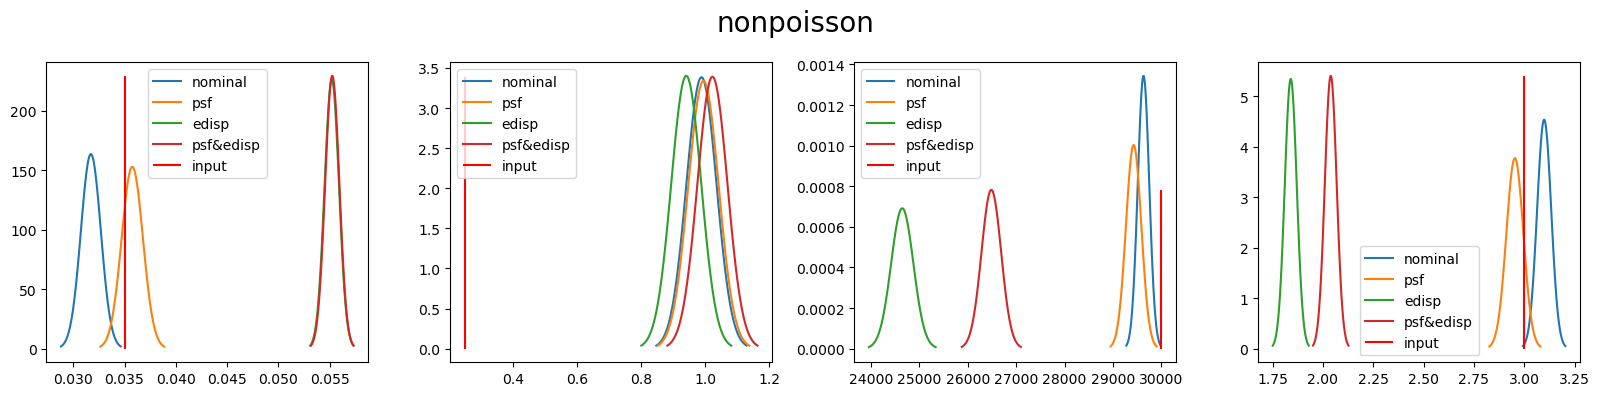

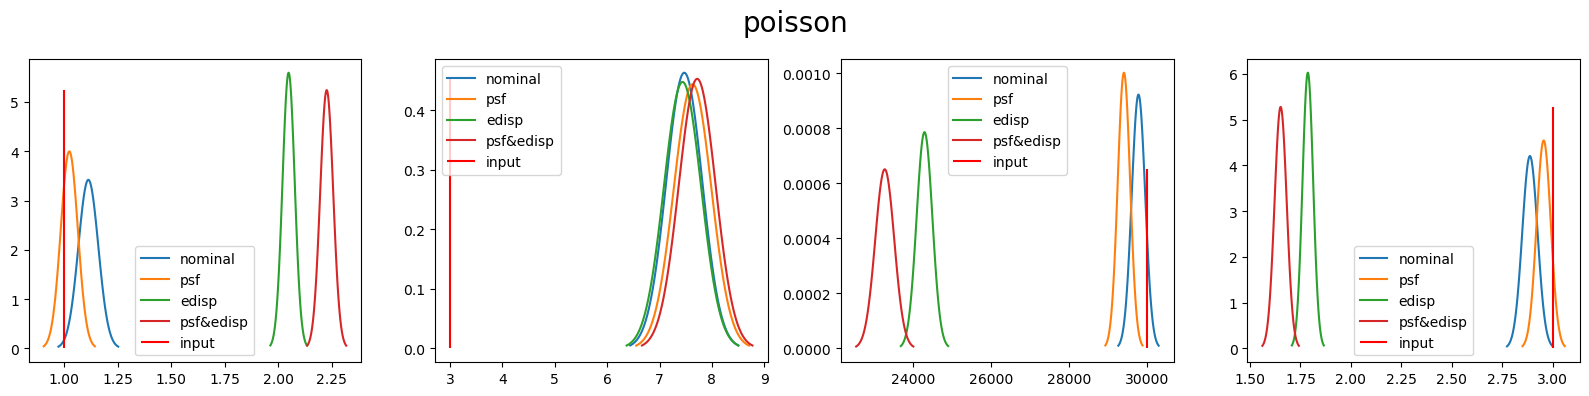

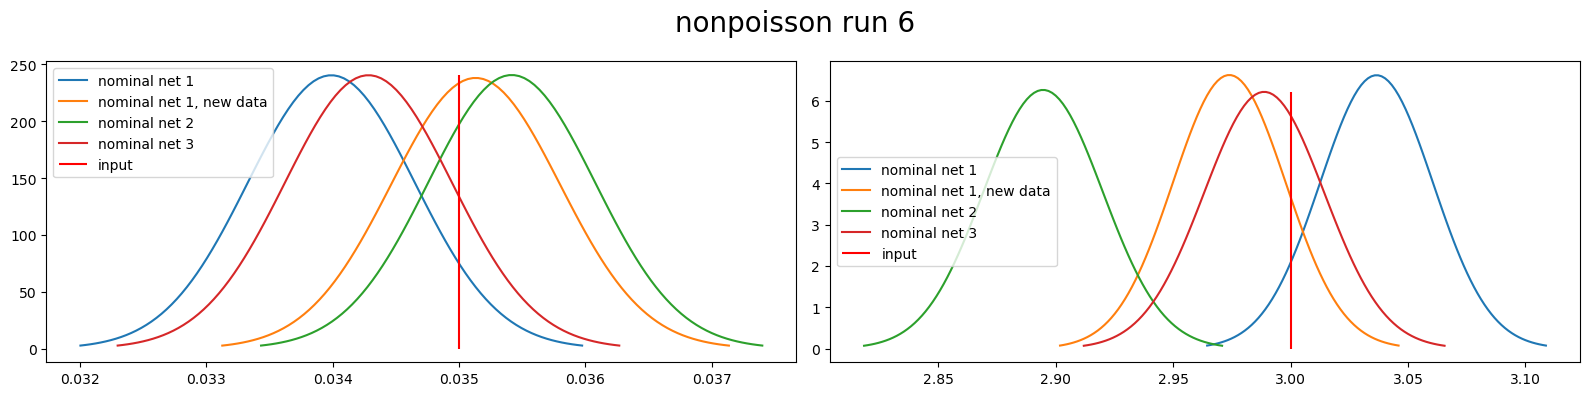

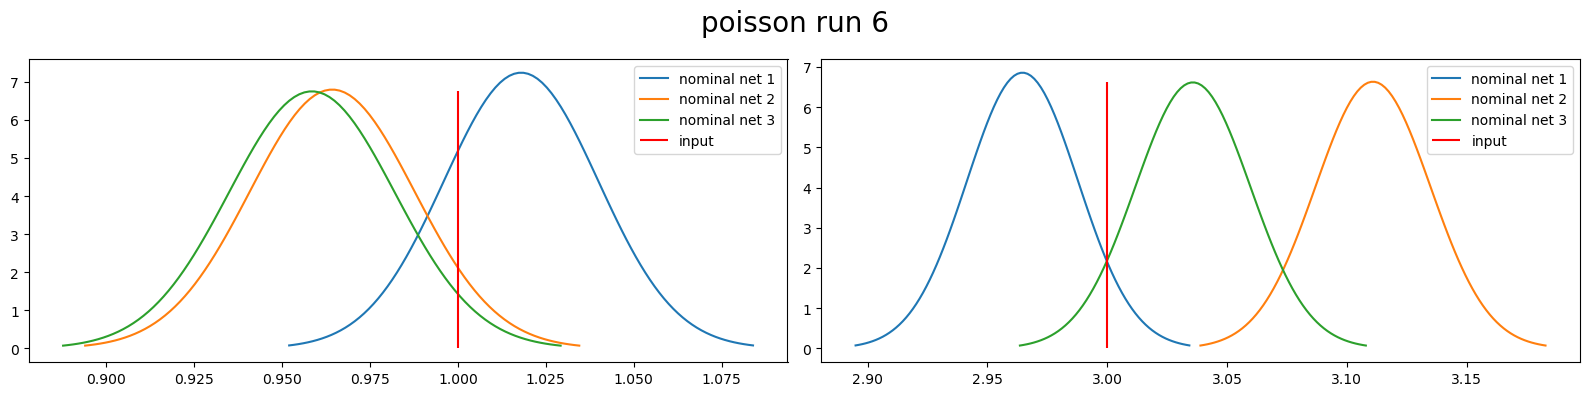

In [31]:
#run5_nonpoisson network, run5_nonpoisson data
input_params = [0.035, 0.25, 30000, 3]
#means = [3.33408155e-02, 9.87281948e-01, 3.03651683e+04, 3.19443949e+00] #before separate gen and mask cuts
#sigs =  [6.32075833e-04, 4.71265387e-02, 2.15721894e+02, 5.82918544e-02] #before separate gen and mask cuts
means = [3.17144840e-02, 9.88595929e-01, 2.96297564e+04, 3.09862815e+00]
sigs =  [9.72130524e-04, 4.70166907e-02, 1.18406420e+02, 3.51013903e-02]
fig, ax = plt.subplots(1,np.size(input_params),figsize=(16,4))
fig.suptitle('nonpoisson', fontsize=20)
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'nominal')

#run5a_nonpoisson network, run5_nonpoisson data:
input_params = [0.035, 0.25, 30000, 3]
#means = [3.43799043e-02, 9.94454757e-01, 3.03102583e+04, 3.08682232e+00] #before separate gen and mask cuts
#sigs = [6.40077814e-04, 4.71975104e-02, 2.31750387e+02, 6.00901373e-02] #before separate gen and mask cuts
means = [3.57554142e-02, 9.94836575e-01, 2.94258967e+04, 2.95320183e+00]
sigs =  [1.04017069e-03, 4.76626236e-02, 1.58657322e+02, 4.22026573e-02]
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'psf')

#run5b_nonpoisson network, run5_nonpoisson data:
input_params = [0.035, 0.25, 30000, 3]
means = [5.52172745e-02, 9.41110364e-01, 2.46474245e+04, 1.84042601e+00]
sigs =  [7.03803060e-04, 4.67718924e-02, 2.30095596e+02, 2.97962824e-02]
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'edisp')

#run5c_nonpoisson network, run5_nonpoisson data:
input_params = [0.035, 0.25, 30000, 3]
#means = [4.45905679e-02, 9.66044933e-01, 1.19473226e+04, 3.58845335e+00] #before separate gen and mask cuts
#sigs = [5.29090553e-04, 4.77871797e-02, 1.27079486e+02, 6.01768543e-02] #before separate gen and mask cuts
means = [5.52634520e-02, 1.02281131e+00, 2.64869874e+04, 2.03896102e+00]
sigs =  [6.93373532e-04, 4.69286993e-02, 2.03421565e+02, 2.94564968e-02]
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'psf&edisp')
    ax[i].vlines(x=input_params[i],ymin=0,ymax=np.max(y), color = 'r', label = 'input')
    ax[i].legend()
plt.tight_layout()

#run5_poisson network, run5_poisson data:
input_params = [1., 3.0, 30000, 3]
#means = [9.63419173e-01, 7.41345708e+00, 2.99059149e+04, 3.02346302e+00] #before separate gen and mask cuts
#sigs = [3.72730703e-02, 3.60151225e-01, 2.11075097e+02, 8.00563755e-02] #before separate gen and mask cuts
means = [1.11220509e+00, 7.47261470e+00, 2.97746877e+04, 2.88706929e+00]
sigs =  [4.65203457e-02, 3.43668710e-01, 1.72519122e+02, 3.78659988e-02]
fig, ax = plt.subplots(1,np.size(input_params),figsize=(16,4))
fig.suptitle('poisson', fontsize=20)
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'nominal')
    
#run5a_poisson network, run5_poisson data:
input_params = [1., 3.0, 30000, 3]
#means = [9.87932159e-01, 7.37014899e+00, 3.06019078e+04, 2.94806901e+00] #before separate gen and mask cuts
#sigs = [3.19412399e-02, 3.52414195e-01, 1.97176917e+02, 7.29500762e-02] #before separate gen and mask cuts
means = [1.02317719e+00, 7.63149613e+00, 2.94016886e+04, 2.95524410e+00]
sigs =  [3.98238802e-02, 3.58619959e-01, 1.58836632e+02, 3.50282575e-02]
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'psf')

#run5b_poisson network, run5_poisson data:
input_params = [1., 3.0, 30000, 3]
means = [2.04765283e+00, 7.43889958e+00, 2.42863491e+04, 1.78647404e+00]
sigs =  [2.84577143e-02, 3.55545248e-01, 2.02499526e+02, 2.64237450e-02]
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'edisp')

#run5c_poisson network, run5_poisson data:
input_params = [1., 3.0, 30000, 3]
#means = [1.69205919e+00, 7.30832098e+00, 1.20637016e+04, 2.91367661e+00] #before separate gen and mask cuts
#sigs = [2.97286759e-02, 3.63144089e-01, 1.52005561e+02, 7.11817802e-02] #before separate gen and mask cuts
means = [2.22562313e+00, 7.71932708e+00, 2.32668327e+04, 1.65164490e+00]
sigs =  [3.03756592e-02, 3.51446508e-01, 2.44427732e+02, 3.01635104e-02]
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'psf&edisp')
    ax[i].vlines(x=input_params[i],ymin=0,ymax=np.max(y), color = 'r', label = 'input')
    ax[i].legend()
plt.tight_layout()

#run6_nonpoisson network, run6_nonpoisson data
input_params = [0.035, 3]
means = [0.0339882,  3.03656037]
sigs =  [0.00066181, 0.02404625]
fig, ax = plt.subplots(1,np.size(input_params),figsize=(16,4))
fig.suptitle('nonpoisson run 6', fontsize=20)
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'nominal net 1')
    
#run6_nonpoisson network, new run6_nonpoisson data
input_params = [0.035, 3]
means = [0.03513038, 2.97385976]
sigs =  [0.00066833, 0.024029  ]
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'nominal net 1, new data')

#run6-2_nonpoisson network, run6_nonpoisson data
input_params = [0.035, 3]
means = [0.035416, 2.8945471]
sigs =  [0.0006612, 0.02541348]
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'nominal net 2')
    
#run6-3_nonpoisson network, run6_nonpoisson data
input_params = [0.035, 3]
means = [0.03428245, 2.98871443]
sigs =  [0.00066169, 0.02560648]
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'nominal net 3')
    ax[i].vlines(x=input_params[i],ymin=0,ymax=np.max(y), color = 'r', label = 'input')
    ax[i].legend()
plt.tight_layout()

#run6_poisson network, run6_poisson data
input_params = [1, 3]
means = [1.01796916, 2.96461367]
sigs =  [0.02198728, 0.02322299]
fig, ax = plt.subplots(1,np.size(input_params),figsize=(16,4))
fig.suptitle('poisson run 6', fontsize=20)
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'nominal net 1')
    
#run6-2_poisson network, run6_poisson data
input_params = [1, 3]
means = [0.96425096, 3.1109443 ]
sigs =  [0.02342142, 0.02400975]
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'nominal net 2')
    
#run6-2_poisson network, run6_poisson data
input_params = [1, 3]
means = [0.95846163, 3.03575863]
sigs =  [0.02358359, 0.02407003]
for i in range(np.size(input_params)):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    ax[i].plot(x,y, label = 'nominal net 3')
    ax[i].vlines(x=input_params[i],ymin=0,ymax=np.max(y), color = 'r', label = 'input')
    ax[i].legend()
plt.tight_layout()

In [29]:
#Test photon loss from psf and energy disp
params = [0.035, 0.25, 30000, 3]
source_info = my_LFI.create_sources(params, grains = 4000)
photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
obs_photon_info_postpsf = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = True, single_energy_value = 5400)
obs_photon_info_postedisp = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = True, single_energy_value = 54)
num_raw = np.size(obs_photon_info['energies'])
num_postpsf = np.size(obs_photon_info_postpsf['energies'])
num_postedisp = np.size(obs_photon_info_postedisp['energies'])
print(num_raw, num_postpsf, num_postedisp)

103804 103804 103804


In [ ]:
print(mcsamples.confidence(0, 0.05, upper = False))
print(mcsamples.confidence(0, 0.05, upper = True))

#### num_sims = 50
confidence = 0.025

num_in_conf = np.zeros(len(input_params))
for i in range(num_sims):
    observation = simulator(input_params)
    samples = posterior.sample((10000,), x=observation) #100000
    ranges = dict(zip(parameter_names, np.array(parameter_range).T.reshape((np.array(parameter_range[0]).size,2))))
    mcsamples = MCSamples(samples=samples.numpy(), names = parameter_names, labels = parameter_names, ranges = ranges)
    for i in range(len(input_params)): 
        low = mcsamples.confidence(i, confidence, upper = False)
        high = mcsamples.confidence(i, confidence, upper = True)
        if low < input_params[i] and input_params[i] < high:
            num_in_conf[i] += 1

print(num_in_conf/num_sims)    